In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd 
from pathlib import Path
import scipy 
from tqdm import tqdm
from PIL import Image

In [3]:
# Train_dir = "/Users/sara/Downloads/archive (4)/train"
# Test_dir = "/Users/sara/Downloads/archive (4)/test"
# Validation_dir = "/Users/sara/Downloads/archive (4)/validation"

# Loading the data

In [4]:
# Create a list with the filepaths for training and testing
train_dir = Path("/Users/sara/Downloads/archive (4)/train")
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path("/Users/sara/Downloads/archive (4)/test")
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path("/Users/sara/Downloads/archive (4)/validation")
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)


In [5]:
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

Number of pictures: 2780

Number of different labels: 36

Labels: ['carrot' 'kiwi' 'cabbage' 'chilli pepper' 'corn' 'jalepeno' 'eggplant'
 'watermelon' 'pomegranate' 'sweetcorn' 'lemon' 'soy beans' 'cucumber'
 'grapes' 'banana' 'raddish' 'peas' 'lettuce' 'ginger' 'garlic' 'spinach'
 'beetroot' 'pear' 'pineapple' 'capsicum' 'mango' 'paprika' 'apple'
 'sweetpotato' 'orange' 'cauliflower' 'onion' 'turnip' 'tomato'
 'bell pepper' 'potato']


In [6]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,/Users/sara/Downloads/archive (4)/train/carrot...,carrot
1,/Users/sara/Downloads/archive (4)/train/kiwi/I...,kiwi
2,/Users/sara/Downloads/archive (4)/train/cabbag...,cabbage
3,/Users/sara/Downloads/archive (4)/train/chilli...,chilli pepper
4,/Users/sara/Downloads/archive (4)/train/corn/I...,corn


# Ploting our train data

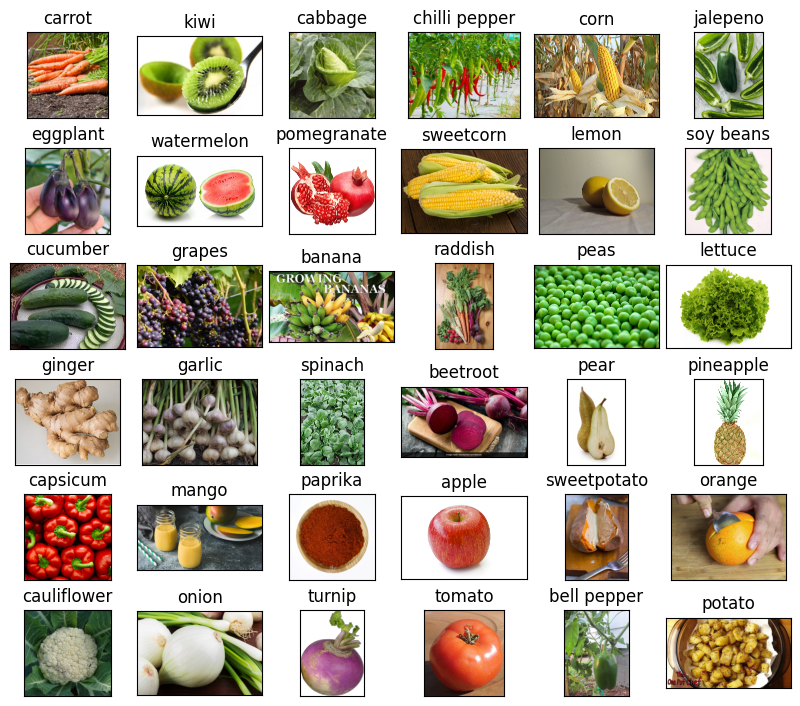

In [7]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Loading the Images with a generator and Data Augmentation #

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


# Loading VGG16 model

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    
    return model

### note that include_top=False removes the final dense layers of the VGG16 model, which will be replaced with our own custom layers for our specific dataset

In [10]:
model = load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Freezing the layers ensures that their weights are not updated during the training process
def set_nontrainable_layers(model):
    
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

In [12]:
model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Transfer Learning 

In [13]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(36, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [14]:
model = add_last_layers(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 500)               12544500  
                                                                 
 dense_1 (Dense)             (None, 36)                18036     
                                                                 
Total params: 27,277,224
Trainable params: 12,562,536
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
from tensorflow.keras import optimizers

def build_model():
  
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [16]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 500)               12544500  
                                                                 
 dense_3 (Dense)             (None, 36)                18036     
                                                                 
Total params: 27,277,224
Trainable params: 12,562,536
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Training our new model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(train_images, 
                    validation_data=val_images, 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[es])

Epoch 1/50


2023-03-14 11:31:14.922352: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


87/87 [==============================] - 432s 5s/step - loss: 2.3224 - accuracy: 0.4014 - val_loss: 0.5152 - val_accuracy: 0.8892
Epoch 2/50
87/87 [==============================] - 462s 5s/step - loss: 0.6902 - accuracy: 0.8399 - val_loss: 0.2601 - val_accuracy: 0.9551
Epoch 3/50
87/87 [==============================] - 489s 6s/step - loss: 0.2731 - accuracy: 0.9604 - val_loss: 0.1777 - val_accuracy: 0.9641
Epoch 4/50
87/87 [==============================] - 520s 6s/step - loss: 0.1271 - accuracy: 0.9867 - val_loss: 0.1620 - val_accuracy: 0.9671
Epoch 5/50
87/87 [==============================] - 542s 6s/step - loss: 0.0838 - accuracy: 0.9896 - val_loss: 0.1471 - val_accuracy: 0.9611
Epoch 6/50
87/87 [==============================] - 569s 7s/step - loss: 0.0750 - accuracy: 0.9896 - val_loss: 0.1295 - val_accuracy: 0.9701
Epoch 7/50
87/87 [==============================] - 634s 7s/step - loss: 0.0710 - accuracy: 0.9885 - val_loss: 0.1287 - val_accuracy: 0.9671
Epoch 8/50
87/87 [======

# Saving the model and its weight for future use 

In [19]:
model.save("model.h5")

Save the model weights to a dictionary

In [26]:
weights = {}
for i, layer in enumerate(model.layers):
    layer_weights = layer.get_weights()
    weights[f'layer_{i}'] = layer_weights

In [ ]:
import pickle

with open('model_weights.pkl', 'wb') as file:
    pickle.dump(weights, file)

In [20]:
# Loding the model and its weight for future use 

# from tensorflow.keras.models import load_model

# # Load the saved model and its weights
# model = load_model("model.h5")

# Ploting the history

In [21]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

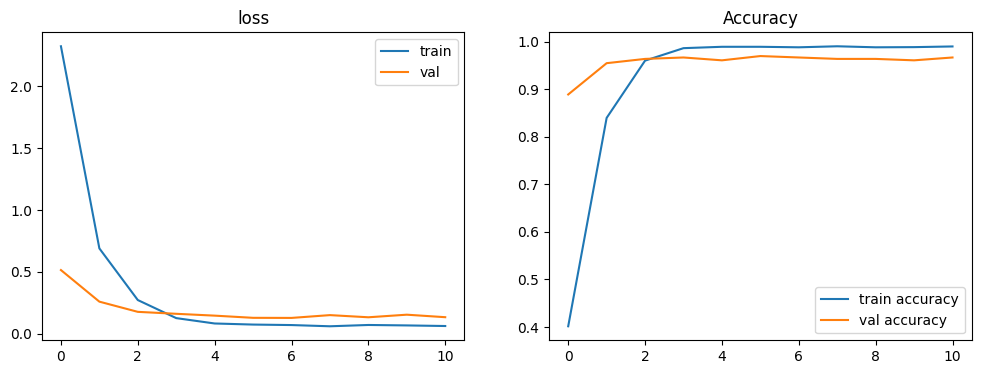

In [22]:
plot_history(history)

# Creating a prediction function 

In [23]:
def predict_function(pred_dir):
    # pred_dir = Path("/Users/sara/Downloads/archive (4)/test")
    pred_filepaths = list(pred_dir.glob(r'**/*.jpg'))
    #Start here in streamlit
    #what is the type of image, then convert it (jpg, jpeg, png, bmp, tiff)
    #pred_df = proc_img(list(user_input))

    pred_df = proc_img(pred_filepaths)
    pred_img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    pred_images = pred_img_generator.flow_from_dataframe(
        dataframe=pred_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
        #predict me!
    result = model.predict(pred_images)
    predicted_probabilities = np.argmax(result,axis=1)
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in predicted_probabilities]
    pred
    
    print('prediction, actual, correct?')
    # zip the predictions with the inputs so we can check if the prediction is correct
    for curr_pred, curr_path in zip(pred, list(pred_df.Filepath)):
        # take the folder name from the file path because the folder name is the type food
        actual = curr_path.split('/')[-2]
        is_correct = curr_pred == actual
        print(f'{curr_pred}, {actual}, {is_correct}')
        
    # a = [curr_pred, curr_path for curr_pred, curr_path in zip(pred, list(pred_df.Filepath)) where curr_pred!=curr_path.split('/')[-2] ]

In [24]:
predict_function(Path("/Users/sara/Downloads/archive (4)/test"))

Found 334 validated image filenames belonging to 36 classes.
11/11 [==============================] - 45s 4s/step
prediction, actual, correct?
lettuce, lettuce, True
turnip, turnip, True
jalepeno, jalepeno, True
garlic, garlic, True
lettuce, lettuce, True
tomato, tomato, True
banana, banana, True
cabbage, cabbage, True
eggplant, eggplant, True
beetroot, beetroot, True
garlic, garlic, True
orange, orange, True
capsicum, capsicum, True
pineapple, pineapple, True
paprika, paprika, True
garlic, garlic, True
beetroot, beetroot, True
ginger, ginger, True
spinach, spinach, True
soy beans, soy beans, True
turnip, turnip, True
bell pepper, bell pepper, True
capsicum, capsicum, True
pear, pear, True
eggplant, eggplant, True
beetroot, beetroot, True
kiwi, kiwi, True
capsicum, capsicum, True
beetroot, beetroot, True
grapes, grapes, True
grapes, grapes, True
lettuce, lettuce, True
turnip, turnip, True
corn, corn, True
raddish, raddish, True
peas, peas, True
pineapple, pineapple, True
pear, apple, F

# Testing with a random images from the web 

In [25]:
predict_function(Path("/Users/sara/Downloads/lemon"))

Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 148ms/step
prediction, actual, correct?
lemon, lemon, True
